# Part 1-Data Extraction and Data cleaning

This is part one of project where i tried to fetch required data with human faces and Girl/Boy/Woman/Man labels and kept it in parquest file to use it further to fit model

Below are the necessary modules which needs to be imported as pre-requisites

#!pip install --cache-dir='/scratch/data603/msitut1' tensorflow==2.2.0rc2
pip3 install --no-cache-dir tensorflow
pip install Pillow
pip install matplotlib
pip install cvlib
pip install opencv-python
pip install import_ipynb
pip install pyarrow
pip install pyspark
pip install venv_pack
pip install pandas
pip install keras

## Loading Libraries

In [1]:
# Loading libraries

import import_ipynb
import SparkLauncher, HDFS.ipynb
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import lit
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import os
import pyarrow as pa
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import venv_pack
from pyspark.sql.functions import array_contains
import io
from io import StringIO
import pyspark.sql.functions as f
import cv2
import tensorflow
import model
import cvlib as cv
import numpy as np
import pandas as pd

importing Jupyter notebook from SparkLauncher.ipynb
Creating Spark Configuration
importing Jupyter notebook from HDFS.ipynb
importing Jupyter notebook from model.ipynb


Using TensorFlow backend.


## Creating Spark Session

In [2]:
# loading spark context
spark= SparkLauncher.get_spark_session()
hdfs = HDFS.get_hdfs()

Packing Virtual Environment: msitut1.tar.gz
Setting Environment Variables
Creating Spark Session: msitut1_data603_spark_session


In [3]:
hdfs.ls('/data/google_open_image')

['/data/google_open_image/bboxes',
 '/data/google_open_image/ids',
 '/data/google_open_image/images',
 '/data/google_open_image/labels',
 '/data/google_open_image/masks',
 '/data/google_open_image/metadata',
 '/data/google_open_image/relationships',
 '/data/google_open_image/segmentations']

## Data Loading and Creating Dataframes

In [4]:
#creating dataframes
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("LabelName", StringType(), True),
    StructField("Items", StringType(), True),
])

df_description_box=spark.read.csv('/data/google_open_image/metadata/class-descriptions-boxable.csv', header = False,schema=schema)

In [5]:
# Shape of all the dataframes
print('df_description_box',(df_description_box.count(), len(df_description_box.columns)))
df_description_box.printSchema()

df_description_box (601, 2)
root
 |-- LabelName: string (nullable = true)
 |-- Items: string (nullable = true)



Checking if df_description_box has any null values

In [6]:
### Get count of nan or missing values in pyspark

from pyspark.sql.functions import isnan, when, count, col
df_description_box.select([count(when(isnan(c), c)).alias(c) for c in df_description_box.columns]).show()
    #http://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/

+---------+-----+
|LabelName|Items|
+---------+-----+
|        0|    0|
+---------+-----+



No null values observed in df_description_box dataframe

In [7]:
#dataframe that contain specific image ids

df_specific_description_box_v1=df_description_box.filter((f.col('Items') == 'Human face')| (f.col('Items') == 'Woman')\
                                                     |(f.col('Items') == 'Man')| (f.col('Items') == 'Boy')\
                                                      |(f.col('Items') == 'Girl'))
df_specific_description_box_v1.show()
#Reference - http://www.datasciencemadesimple.com/subset-or-filter-data-with-multiple-conditions-in-pyspark/

+----------+----------+
| LabelName|     Items|
+----------+----------+
| /m/01bl7v|       Boy|
|/m/03bt1vf|     Woman|
|  /m/04yx4|       Man|
| /m/05r655|      Girl|
|  /m/0dzct|Human face|
+----------+----------+



In [8]:
sc=SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [9]:
df_labels = spark.read.format("com.databricks.spark.csv").option("header", "true").load("/data/google_open_image/labels/*.csv")
#Reference-https://stackoverflow.com/questions/44558139/how-to-read-csv-without-header-and-name-them-with-names-while-reading-in-pyspark

In [10]:
# Shape of all the dataframes
print('df_labels',(df_labels.count(), len(df_labels.columns)))
df_labels.printSchema()

df_labels (10026278, 4)
root
 |-- ImageID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- LabelName: string (nullable = true)
 |-- Confidence: string (nullable = true)



Checking if df_labels has any null values

In [11]:
### Get count of nan or missing values in pyspark

from pyspark.sql.functions import isnan, when, count, col
df_labels.select([count(when(isnan(c), c)).alias(c) for c in df_labels.columns]).show()
#http://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/

+-------+------+---------+----------+
|ImageID|Source|LabelName|Confidence|
+-------+------+---------+----------+
|      0|     0|        0|         0|
+-------+------+---------+----------+



No null values observed in df_labels dataframe

### EDA 1 -Top 10 different labels with highest number of Images available in them.

In [15]:
from pyspark.sql.functions import desc

df_visualize1=df_labels.groupBy('LabelName').count().sort(desc("count"))
df_visualize1=df_visualize1.withColumnRenamed("count","Total")

In [16]:
df_visualize1.printSchema()


root
 |-- LabelName: string (nullable = true)
 |-- Total: long (nullable = false)



In [17]:
df_visualize1 = df_visualize1.toPandas()
df_visualize1=df_visualize1.head(10)


In [18]:
df_visualize1=pd.merge(df_visualize1,df_description_box.filter(col("LabelName").isin(list(df_visualize1.LabelName))).toPandas(), on=['LabelName'])
#https://stackoverflow.com/questions/44781633/join-pandas-dataframes-based-on-column-values

In [19]:
df_visualize1

,LabelName,Total,Items
0,/m/01g317,892037,Person
1,/m/09j2d,720911,Clothing
2,/m/04yx4,492675,Man
3,/m/05s2s,486300,Plant
4,/m/07j7r,458747,Tree
5,/m/0dzct,410061,Human face
6,/m/03bt1vf,393642,Woman
7,/m/05r655,299439,Girl
8,/m/07yv9,283084,Vehicle
9,/m/0cgh4,272843,Building


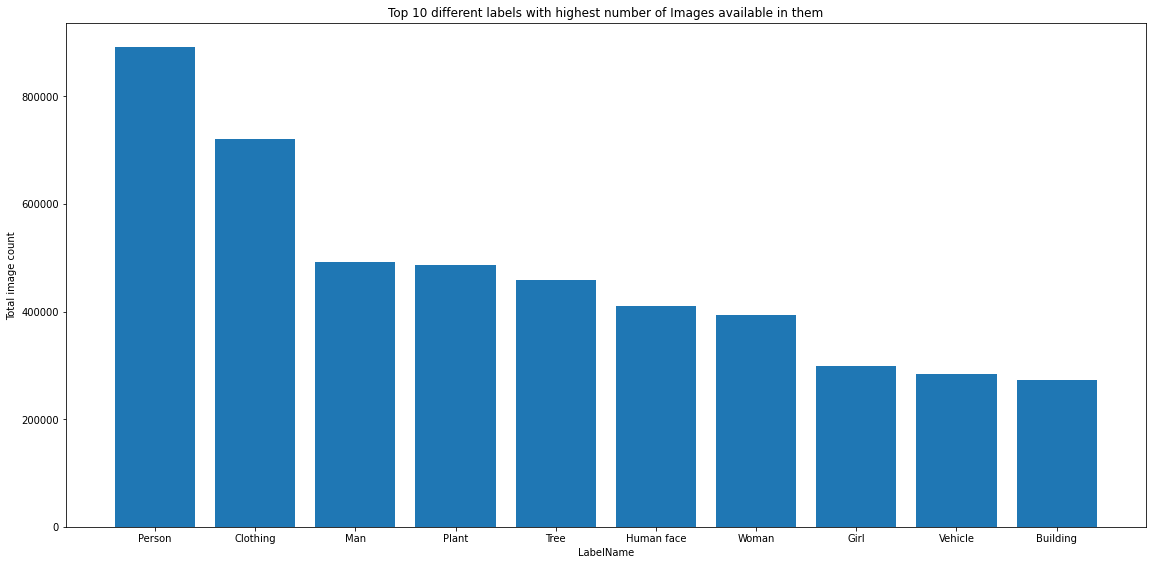

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = list(df_visualize1.Items)
Y = list(df_visualize1.Total)
ax.bar(X,Y)
ax.set_ylabel('Total image count')
ax.set_xlabel('LabelName')
ax.set_title('Top 10 different labels with highest number of Images available in them')
fig.set_size_inches(15, 7)
#https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.html

In [28]:
#Carrying out labels with specific values
df_labels_v2=df_labels.filter((f.col('LabelName') == '/m/0dzct') | (f.col('LabelName') == '/m/03bt1vf')\
                               | (f.col('LabelName') == '/m/04yx4') | (f.col('LabelName') == '/m/05r655')\
                               | (f.col('LabelName') == '/m/0dzct')
                              )


In [29]:
#Grouping by ImageIDs and concatenating Labelnames
df_labels_v3=df_labels_v2.groupby("ImageID").agg(f.concat_ws(", ", f.collect_list(df_labels_v2.LabelName)).alias("LabelName"),
                                                     f.collect_list(df_labels_v2.Confidence))
df_labels_v3=df_labels_v3.withColumnRenamed("collect_list(Confidence)","Confidence_concat")


#Reference - https://stackoverflow.com/questions/41788919/concatenating-string-by-rows-in-pyspark

This above dataframe contains image ids with human face and along with man and woman . 
We need human face and (man/woman/girl/boy) image id indiviually . 
for that we will carry out images id with label name as 'Human face' and 'Girl'/'Boy'/'Woman'/'Man'

In [30]:
df_labels_concat_v4=df_labels_v3.filter(
    (f.col('LabelName') == '/m/0dzct, /m/01bl7v')\
    |(f.col('LabelName') == '/m/0dzct, /m/03bt1vf')\
    |(f.col('LabelName') == '/m/0dzct, /m/04yx4')\
    |(f.col('LabelName') == '/m/0dzct, /m/05r655')\
    |(f.col('LabelName') == '/m/05r655, /m/0dzct')\
    |(f.col('LabelName') == '/m/04yx4, /m/0dzct')\
    |(f.col('LabelName') == '/m/03bt1vf, /m/0dzct')\
    |(f.col('LabelName') == '/m/01bl7v, /m/0dzct')\
)

In [31]:
df_labels_concat_v4.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = false)
 |-- Confidence_concat: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [32]:
df_labels_concat_v4.select('Confidence_concat').distinct().show()

+-----------------+
|Confidence_concat|
+-----------------+
|           [1, 1]|
|           [0, 1]|
|           [0, 0]|
|           [1, 0]|
+-----------------+



Only imageID's with high confidence would be used as features.

In [33]:
#Using UDF to carry out good images nad bad images using confidence column
#https://stackoverflow.com/questions/51383298/how-to-create-new-column-based-on-values-in-array-column-in-pyspark
def any_isin(ref_values, array_to_search):
    label = 'none'
    for key, values in ref_values.items():
        if any(item in array_to_search for item in values):
            label=key
            break
    return label

any_isin_udf = lambda ref_values: (
    f.udf(lambda array_to_search: any_isin(ref_values, array_to_search), StringType())
)



In [73]:
good_or_bad_images_code={'Bad Image': ['0','1'],
                       'Bad Image': ['1','0'],
                       'Bad Image': ['0','0'],
                       'Good Image': ['1','1']}

df_labels_concat_v5 = df_labels_concat_v4.withColumn('Good/Bad', any_isin_udf(good_or_bad_images_code)(f.col('Confidence_concat')))


In [74]:
df_labels_concat_v5.count()

105518

In [75]:
df_labels_concat_v6 = df_labels_concat_v5.withColumn(
    'Target_Label',
    f.when((f.col("LabelName") == '/m/0dzct, /m/01bl7v'), 'Male')\
    .when((f.col("LabelName") == '/m/0dzct, /m/03bt1vf'), 'Female')\
    .when((f.col("LabelName") == '/m/0dzct, /m/04yx4'), 'Male')\
    .when((f.col("LabelName") == '/m/0dzct, /m/05r655'), 'Female')\
    .when((f.col("LabelName") == '/m/05r655, /m/0dzct'), 'Female')\
    .when((f.col("LabelName") == '/m/04yx4, /m/0dzct'), 'Male')\
    .when((f.col("LabelName") == '/m/03bt1vf, /m/0dzct'), 'Female')\
    .when((f.col("LabelName") == '/m/01bl7v, /m/0dzct'), 'Male')\
)
#https://stackoverflow.com/questions/51565395/pyspark-create-new-column-and-fill-in-based-on-conditions-of-two-other-columns

In [76]:
df_labels_concat_v6.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = false)
 |-- Confidence_concat: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Good/Bad: string (nullable = true)
 |-- Target_Label: string (nullable = true)



In [77]:
df_labels_concat_v6.select('Target_Label').distinct().show()

+------------+
|Target_Label|
+------------+
|      Female|
|        Male|
+------------+



### EDA 2 -Count of Good images and Bad images of Human Face for Male and Female indiviually


In [97]:
df_visualize2=df_labels_concat_v6.groupBy('Target_Label','Good/Bad').count()
df_visualize2=df_visualize2.withColumnRenamed("count","Total")
df_visualize2.show()

+------------+----------+-----+
|Target_Label|  Good/Bad|Total|
+------------+----------+-----+
|        Male|Good Image|60088|
|      Female| Bad Image|16545|
|      Female|Good Image|17889|
|        Male| Bad Image|10996|
+------------+----------+-----+



In [123]:
df_visualize2_pandas=df_visualize2.toPandas()

In [124]:
#df_visualize2_pandas=df_visualize2_pandas.set_index('Target_Label')

In [125]:
df_visualize2_pandas

,Target_Label,Good/Bad,Total
0,Male,Good Image,60088
1,Female,Bad Image,16545
2,Female,Good Image,17889
3,Male,Bad Image,10996


In [136]:
# creating separate dataframe for male and femalet
df_visualize2_1=df_visualize2.filter((f.col('Good/Bad') == 'Good Image'))
df_visualize2_2=df_visualize2.filter((f.col('Good/Bad') == 'Bad Image'))


In [137]:
df_visualize2_1=df_visualize2_1.toPandas()
df_visualize2_2=df_visualize2_2.toPandas()

In [149]:
#df_visualize2_1=df_visualize2_1.set_index('Target_Label')
df_visualize2_1=df_visualize2_1.sort_index(ascending=False)
df_visualize2_1

,Target_Label,Good/Bad,Total
1,Female,Good Image,17889
0,Male,Good Image,60088


In [150]:
#df_visualize2_2=df_visualize2_2.set_index('Target_Label')
df_visualize2_2

,Target_Label,Good/Bad,Total
0,Female,Bad Image,16545
1,Male,Bad Image,10996


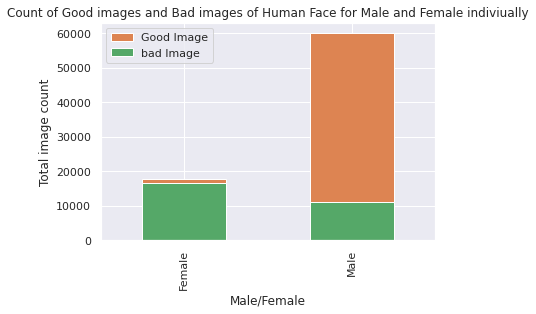

In [156]:
#plotting data using matplotlib
ax = df_visualize2_1.plot(x='Target_Label', y='Total', kind="bar", color ="C1")
df_visualize2_2.plot(x="Target_Label", y="Total", kind="bar", ax=ax, color="C2")
ax.set_ylabel('Total image count')
ax.set_xlabel('Male/Female')
ax.set_title('Count of Good images and Bad images of Human Face for Male and Female indiviually')
ax.legend(labels=['Good Image', 'bad Image'])
plt.show()

In [79]:
#Carrying out only images with good images

In [80]:
df_labels_concat_v7=df_labels_concat_v6.filter((f.col('Good/Bad') == 'Good Image'))

In [81]:
df_labels_concat_v7.count()

77977

In [82]:
df_labels_concat_v7.limit(5).toPandas()

,ImageID,LabelName,Confidence_concat,Good/Bad,Target_Label
0,001094620459cb98,"/m/04yx4, /m/0dzct","[1, 1]",Good Image,Male
1,001bf60cd96147ea,"/m/05r655, /m/0dzct","[1, 1]",Good Image,Female
2,003bc013f9dd0aef,"/m/04yx4, /m/0dzct","[1, 1]",Good Image,Male
3,0178e24a337652ef,"/m/04yx4, /m/0dzct","[1, 1]",Good Image,Male
4,018e424b73f04e52,"/m/04yx4, /m/0dzct","[1, 1]",Good Image,Male


In [83]:
df_labels_concat_v7.select('LabelName').distinct().show()

+--------------------+
|           LabelName|
+--------------------+
|/m/03bt1vf, /m/0dzct|
| /m/05r655, /m/0dzct|
|/m/0dzct, /m/03bt1vf|
|  /m/0dzct, /m/04yx4|
| /m/0dzct, /m/05r655|
|  /m/04yx4, /m/0dzct|
+--------------------+



In [43]:
# Carrying out 100 images of female and 100 image of male to fit he model for now to save resources
df_sample_data=(df_labels_concat_v7.filter((f.col('Target_Label') == 'Female')).limit(150)).union((df_labels_concat_v7.filter((f.col('Target_Label') == 'Male')).limit(150)))


In [44]:
df_sample_data.count()

300

In [45]:
df_sample_data.printSchema()

root
 |-- ImageID: string (nullable = true)
 |-- LabelName: string (nullable = false)
 |-- Confidence_concat: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Good/Bad: string (nullable = true)
 |-- Target_Label: string (nullable = true)



In [46]:
spark.catalog.clearCache()
sqlContext.clearCache()

In [53]:
#Loading bounding boxes data
df_image_parquet_withdata = spark.read.parquet('/etl/google_open_image/images.parquet')


In [54]:
# Shape of all the dataframes
print('df_image_parquet_withdata',(df_image_parquet_withdata.count(), len(df_image_parquet_withdata.columns)))
df_image_parquet_withdata.printSchema()

df_image_parquet_withdata (1910098, 14)
root
 |-- ImageID: string (nullable = true)
 |-- Subset: string (nullable = true)
 |-- Format: string (nullable = true)
 |-- Data: binary (nullable = true)
 |-- OriginalURL: string (nullable = true)
 |-- OriginalLandingURL: string (nullable = true)
 |-- License: string (nullable = true)
 |-- AuthorProfileURL: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- OriginalSize: string (nullable = true)
 |-- OriginalMD5: string (nullable = true)
 |-- Thumbnail300KURL: string (nullable = true)
 |-- Rotation: string (nullable = true)



Checking if df_image_parquet_withdata has any null values

creating a list of dataframe column names and removing ‘Data’ column from that and giving those specific columns to isnan() method to check for null values.

In [49]:
col_name_parquet=(df_image_parquet_withdata.columns)
col_name_parquet.remove('Data')
col_name_parquet

['ImageID',
 'Subset',
 'Format',
 'OriginalURL',
 'OriginalLandingURL',
 'License',
 'AuthorProfileURL',
 'Author',
 'Title',
 'OriginalSize',
 'OriginalMD5',
 'Thumbnail300KURL',
 'Rotation']

In [50]:
### Get count of nan or missing values in pyspark

from pyspark.sql.functions import isnan, when, count, col
df_image_parquet_withdata.select([count(when(isnan(c), c)).alias(c) for c in col_name_parquet]).toPandas()
#http://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/

,ImageID,Subset,Format,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,0,0,0,0,0,0,0,0,0,0,0,0,0


No null values observed in df_image_parquet_withdata dataframe

In [ ]:
# dropping unwanted columns
df_image_parquet=df_image_parquet_withdata.drop('LabelName','Format','OriginalLandingURL','License','AuthorProfileURL',
            'Author','Title','OriginalSize','OriginalMD5','Thumbnail300KURL','Rotation'
           )
#Reference- from lecture slides

In [ ]:
df_sample_data_v2=df_sample_data.join(df_image_parquet,['ImageID'],"left")


In [ ]:
df_sample_data_v2.printSchema()

In [ ]:
df_sample_data_v2.count()

In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()


In [ ]:
# Read the 3 bounding box csv files.
bounding_boxes_1 = spark.read.csv('/data/google_open_image/bboxes/test-annotations-bbox.csv', header = True)
bounding_boxes_2 = spark.read.csv('/data/google_open_image/bboxes/train-annotations-bbox.csv', header = True)
bounding_boxes_3 = spark.read.csv('/data/google_open_image/bboxes/validation-annotations-bbox.csv', header = True)

# Join the dataframes into a single dataframe.
bounding_boxes = bounding_boxes_1.union(bounding_boxes_2).union(bounding_boxes_3)

In [ ]:
bounding_boxes.count()

In [ ]:
# Verify the schema
bounding_boxes.printSchema()

Checking if df_labels has any null values

In [ ]:
### Get count of nan or missing values in pyspark

from pyspark.sql.functions import isnan, when, count, col
bounding_boxes.select([count(when(isnan(c), c)).alias(c) for c in bounding_boxes.columns]).show()
#http://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/

No null values observed in bounding_boxes dataframe

In [ ]:
bounding_boxes = bounding_boxes.drop('LabelName')

In [ ]:
# Join on ImageID to get just the bounding boxes we have image data for.
df_data = df_sample_data_v2.join(bounding_boxes, on = 'ImageID', how = 'left')

In [ ]:
df_data.printSchema()

In [ ]:
df_data.count()

In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()
#https://stackoverflow.com/questions/36905717/un-persisting-all-dataframes-in-pyspark

Extracting chip_data using udf

In [ ]:
def extract_chip(data, xmin, xmax, ymin, ymax):
    from PIL import Image
    import io, math
    
    # Read the image data using Pillow
    img = Image.open(io.BytesIO(data))
    # Get the size of the image 
    (width, height) = img.size
    
    # Calculate the bounding box pixels
    # observe the use of float function here. That's necessary
    # because the bounding box data were read in as strings, not doubles.
    left = math.floor(float(xmin)*width)
    upper = math.floor(float(ymin)*height)
    right = math.floor(float(xmax)*width)
    lower = math.floor(float(ymax)*height)
    
    # Crop the image to the bounding box size
    img = img.crop(box = (left, upper, right, lower))
    
    # Save the image to a byte-buffer
    buff = io.BytesIO()
    img.save(buff, format = "JPEG")
    
    # Get the raw bytes of the jpeg data.
    byte_array = buff.getvalue()
    return byte_array   # return buff.getvalue() doesn't work. This a quirk of pyspark not being able to determine the output

In [ ]:
# Wrap the function as a spark udf (user-defined function) with a binary return type
udf_extract_chip = f.udf(extract_chip, returnType = BinaryType())

# Create a new column with the image chip data
df_data = df_data.withColumn("chip_data", udf_extract_chip("Data","XMin","XMax","YMin","YMax"))

In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()

In [ ]:
df_data = df_data.drop('data')

In [ ]:
df_data.count()

In [ ]:
df_data.printSchema()

In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()


In [ ]:
df_data.cache()

### Saving dataframe in hdfs

In [ ]:
df_data.write.parquet("/user/msitut1/df_data_no_data.parquet")

In [ ]:
hdfs.ls('/user/msitut1')

In [ ]:
#hdfs.delete('/user/msitut1/df_data_no_data.parquet',recursive=True)

In [ ]:
spark.catalog.clearCache()
sqlContext.clearCache()

Now our data is ready to be used in part 3 - feature extraction

In [ ]:
spark.stop()